In [1]:
# ! pip show tensorflow
# ! pip show tensorflow-gpu
# !pip show keras

In [3]:
!pwd

/masvol/heartsmart/unet_model


In [4]:
#import cv2 
import re, sys
import fnmatch, shutil, subprocess
from IPython.utils import io
import glob
import random

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import numpy as np
from keras.models import *
from keras.layers import Input, concatenate, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import binary_crossentropy
import keras.backend as K

#Fix the random seeds for numpy (this is for Keras) and for tensorflow backend to reduce the run-to-run variance
from numpy.random import seed
seed(100)
from tensorflow import set_random_seed
set_random_seed(200)

import matplotlib.pyplot as plt
%matplotlib inline

print("\nSuccessfully imported packages!!!\n")


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.



Successfully imported packages!!!



In [5]:
import tensorflow as tf

In [6]:
# config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
# #config.gpu_options.per_process_gpu_memory_fraction = 0.4
# #config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)
# #sess.run(yourcommand)

In [7]:
#Settings
TRAIN_TEST_SPLIT_RATIO = 0.1  # train/test split ratio for Sunnybrook and ACDC data

BASE_DIR = "/opt/output/"
SOURCE = "sunnybrook"
SB_SOURCE = "sunnybrook"
ACDC_SOURCE = "acdc"
TRAIN_IMG_DIR = BASE_DIR + SOURCE + "/norm/1/3/images/"
TRAIN_LBL_DIR = BASE_DIR + SOURCE + "/norm/1/3/labels/"

TEST_IMG_DIR = BASE_DIR + SOURCE + "/norm/1/3/images/"
PRED_RESULT_DIR = BASE_DIR + SOURCE + "/norm/1/3/images/"

UNET_TRAIN_DIR = BASE_DIR + SOURCE + "/unet_model/data/"
UNET_MODEL_DIR = BASE_DIR + SOURCE + "/unet_model/models/"


UNET_TRAIN_DIR = "/masvol/heartsmart/unet_model/data/"
UNET_MODEL_DIR = "/masvol/heartsmart/unet_model/models/"

# UNET_TRAIN_DIR = "/opt/heartsmart/unet_model/data/"
# UNET_MODEL_DIR = "/opt/heartsmart/unet_model/models/"

DSB_SOURCE = "dsb"
DSB_TRAIN_IMG_DIR = BASE_DIR + DSB_SOURCE + "/norm/1/3/train/"
DSB_VAL_IMG_DIR = BASE_DIR + DSB_SOURCE + "/norm/1/3/validate/"
DSB_TEST_IMG_DIR = BASE_DIR + DSB_SOURCE + "/norm/1/3/test/"



## Methods to process and save DSB2 data set into 4d numpy arrays

In [8]:
############################################
#
# Methods to process and save DSB2 data set into 4d numpy arrays
#
################################################
def crop_center(img,cropx,cropy):
    x,y = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[startx:startx+cropx, starty:starty+cropy]

def pad_image(img, img_size):
    #print ("input shape : ", img.shape)
    pad_x=0
    pad_y=0
    x,y = img.shape
    if (x<img_size):
        pad_x = img_size - x
    if (y<img_size):
        pad_y = img_size - y
    process_img = np.pad(img, pad_width=((pad_x//2, ((pad_x//2) + (pad_x % 2))), (pad_y//2, ((pad_y//2) + (pad_y % 2)))), mode = 'constant', constant_values = 0)
    #print ("output shape : ", process_img.shape)
    return process_img


def shrink_case(case):
    toks = case.split("-")    
    def shrink_if_number(x):
        try:
            cvt = int(x)
            return str(cvt)
        except ValueError:
            return x
    return "-".join([shrink_if_number(t) for t in toks])

class Image_info_map(object):
    def __init__(self, ctr_path):
        self.ctr_path = ctr_path
        #print (ctr_path)
        #/opt/output/dsb/norm/1/3/test/1111/sax_13_IM-2680-0008.dcm.npy
        match = re.search(r"/([^/]*)/sax_(\d+)_IM-(\d+)-(\d+).dcm.npy", ctr_path)
        #match = re.search(r"/([^/]*)/patient\d+_slice(\d+)_frame(\d+)_label_fix.nii.npy", ctr_path)
        try:
            self.case = shrink_case(match.group(1))
            self.sax_num = int (match.group(2))
            self.record = int(match.group(3))
            self.img_no = int(match.group(4))
        except AttributeError:
            #/opt/output/dsb/norm/1/3/train/234/sax_20_IM-3098-0022-0007.dcm.npy
            match = re.search(r"/([^/]*)/sax_(\d+)_IM-(\d+)-(\d+)-(\d+).dcm.npy", ctr_path)
            self.case = shrink_case(match.group(1))
            self.sax_num = int (match.group(2))
            self.record = int(match.group(3))
            self.img_no = int(match.group(5))
            
    def __str__(self):
        return "<Image info for case %s, record %d image %d>" % (self.case, self.record, self.img_no)
    
def get_dsb_image_list2(data_path):
    image_list = [os.path.join(dirpath,f) 
            for files in glob.glob(data_path+"/*") 
            for dirpath, dirname, infiles in os.walk(files) 
            for f in infiles if f.endswith('dcm.npy')]
    
    print("Number of examples: {:d}".format(len(image_list)))
    #print("Shuffle data")
    #np.random.shuffle(image_list)
    print (image_list[0], image_list[-1])
    
    extracted = list(map(Image_info_map, image_list))
    print ("Image 0 :", extracted[0].case, extracted[0].record, extracted[0].img_no)
    print ("Imae -1 :", extracted[-1].case, extracted[-1].record, extracted[-1].img_no) 
    return image_list, extracted

def get_dsb_image_list(data_path):
    image_list = [os.path.join(data_path,files) 
            for files in glob.glob(data_path+"/*") if files.endswith('dcm.npy')]
    
    print("Number of examples: {:d}".format(len(image_list)))
    #print("Shuffle data")
    #np.random.shuffle(image_list)
    print (image_list[0], image_list[-1])
    
    extracted = list(map(Image_info_map, image_list))
    print ("Image 0 :", extracted[0].case, extracted[0].record, extracted[0].img_no)
    print ("Imae -1 :", extracted[-1].case, extracted[-1].record, extracted[-1].img_no) 
    return image_list, extracted

def get_dsb_images(data_path, crop_size):
    print ("data path: ", data_path)
    img_path_list, extracted_info = get_dsb_image_list(data_path)
    img_count = len(img_path_list)
    print("Processing {:d} images and labels...".format(img_count))
    
    imgs , img_path, ext_info = [], [], []
    for i in range(img_count):

        full_path = img_path_list[i]
        img = np.load(full_path)
        x,y = img.shape

        if x < crop_size or y < crop_size:
            #print ("shapes smaller than crop size", x, y, crop_size)
            img = pad_image(img, crop_size)
            #continue
        if x > crop_size or y > crop_size:
            #print ("img: ", i, x, y, full_path)
            img = crop_center(img,crop_size,crop_size)
            
        imgs.append(img)
        img_path.append(full_path)
        ext_info.append(extracted_info[i])

        if i % (img_count//5) == 0:
            print (full_path)
            plt.imshow(img, cmap = 'gray')
            plt.title('Input Image'), plt.xticks([]), plt.yticks([])
            plt.show()

            #except IOError:
            #    continue
    print ("Final size of image set :", len(imgs), "dropped images:", (img_count - len(imgs)))
                
    return imgs, img_path, ext_info

def convert_images_to_nparray_and_save (imgs, save_file, image_size):
    rows = image_size
    cols = image_size
    i = 0
    print('-'*30)
    print("Converting data to np array, Input size : ",len(imgs))
    print('-'*30)
    
    imgdatas = np.ndarray((len(imgs),rows,cols,1), dtype=np.int)
        
    for idx in range(len(imgs)):
        img = imgs[idx]
        img = img_to_array(img)        
        try:
            imgdatas[i] = img
            i += 1
        except Exception as e:
            print (e)
            continue
        
    np.save(save_file, imgdatas)

    print ("Shape of image array : ", imgdatas.shape)
    print ("Max, min, mean values", imgdatas.max(), imgdatas.min(), imgdatas.mean())
    print('Saved data as: ', save_file)



data path:  /opt/output/dsb/norm/1/3/train/204
Number of examples: 240
/opt/output/dsb/norm/1/3/train/204/sax_51_IM-5940-0008.dcm.npy /opt/output/dsb/norm/1/3/train/204/sax_54_IM-5943-0008.dcm.npy
Image 0 : 204 5940 8
Imae -1 : 204 5943 8
Processing 240 images and labels...
/opt/output/dsb/norm/1/3/train/204/sax_51_IM-5940-0008.dcm.npy


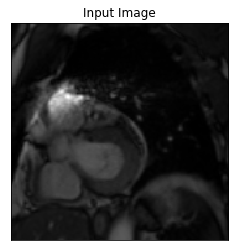

/opt/output/dsb/norm/1/3/train/204/sax_54_IM-5943-0006.dcm.npy


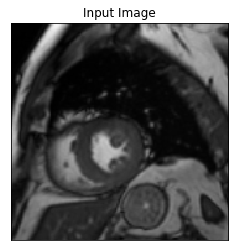

/opt/output/dsb/norm/1/3/train/204/sax_51_IM-5940-0009.dcm.npy


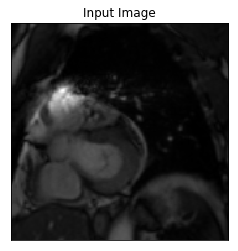

/opt/output/dsb/norm/1/3/train/204/sax_54_IM-5943-0005.dcm.npy


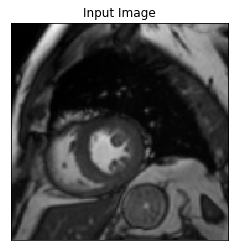

/opt/output/dsb/norm/1/3/train/204/sax_57_IM-5946-0029.dcm.npy


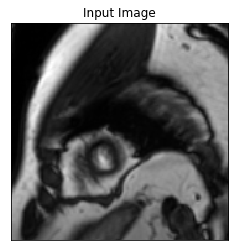

Final size of image set : 240 dropped images: 0
data path:  /opt/output/dsb/norm/1/3/train/204
Number of examples: 240
/opt/output/dsb/norm/1/3/train/204/sax_51_IM-5940-0008.dcm.npy /opt/output/dsb/norm/1/3/train/204/sax_54_IM-5943-0008.dcm.npy
Image 0 : 204 5940 8
Imae -1 : 204 5943 8
Processing 240 images and labels...
/opt/output/dsb/norm/1/3/train/204/sax_51_IM-5940-0008.dcm.npy


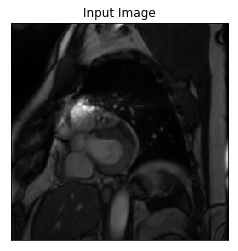

/opt/output/dsb/norm/1/3/train/204/sax_54_IM-5943-0006.dcm.npy


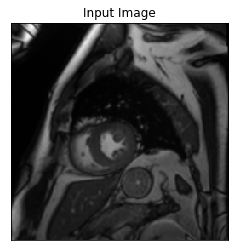

/opt/output/dsb/norm/1/3/train/204/sax_51_IM-5940-0009.dcm.npy


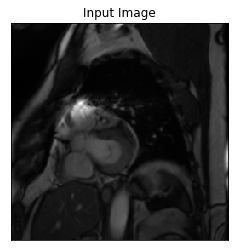

/opt/output/dsb/norm/1/3/train/204/sax_54_IM-5943-0005.dcm.npy


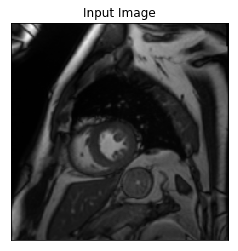

/opt/output/dsb/norm/1/3/train/204/sax_57_IM-5946-0029.dcm.npy


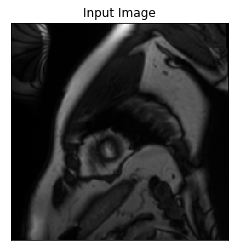

Final size of image set : 240 dropped images: 0
------------------------------
Converting data to np array, Input size :  240
------------------------------
Shape of image array :  (240, 176, 176, 1)
Max, min, mean values 1823 4 212.6733654011708
Saved data as:  /masvol/heartsmart/unet_model/data/dsb204_176.npy
------------------------------
Converting data to np array, Input size :  240
------------------------------
Shape of image array :  (240, 256, 256, 1)
Max, min, mean values 1823 0 202.47705427805582
Saved data as:  /masvol/heartsmart/unet_model/data/dsb204_256.npy


In [24]:
patient_record = "204"
data_path = DSB_TRAIN_IMG_DIR + patient_record
image_list, image_path_list, extracted_info = get_dsb_images(data_path, crop_size=176)
image_list2, image_path_list2, extracted_info2 = get_dsb_images(data_path, crop_size=256)

img_file = UNET_TRAIN_DIR + DSB_SOURCE + patient_record + "_176.npy"
convert_images_to_nparray_and_save (image_list, img_file, image_size = 176)

img_file2 = UNET_TRAIN_DIR + DSB_SOURCE + patient_record + "_256.npy"
convert_images_to_nparray_and_save (image_list2, img_file2, image_size = 256)



# Start from here  if training/test data are already stored in unet_model/data directory

## Methods to load 4d np array for images from ./data directory, perform pixel normalization

In [9]:
#########################################
#
# Methods to load 4d np array for images from ./data directory
# 4D tensor with shape: (samples, rows, cols, channels=1)
#
#########################################

def load_images_and_labels(data):
    print('-'*30)
    print('load np arrays of images and labels...')
    print('-'*30)
    imgfile = data["images"]
    labelfile = data["labels"]
    print ("Loading files : ", imgfile, labelfile)
    
    im = np.load(imgfile)
    lb = np.load(labelfile)
    images = im.astype('float32')
    labels = lb.astype('float32')
    
    ##Normalize the pixel values, (between 0..1)
    x_min = images.min(axis=(1, 2), keepdims=True)
    x_max = images.max(axis=(1, 2), keepdims=True)
    images2 = (images - x_min)/(x_max-x_min)

    print("shape, max, min, mean of original image set:", images.shape, images.max(), images.min(), images.mean())
    print("shape, max, min, mean after normalization  :", images2.shape, images2.max(), images2.min(), images2.mean())
    print("shape, max, min, mean of labels :", labels.shape, labels.max(), labels.min(), labels.mean())
    return images2, labels


def load_images(imgfile):
    print('-'*30)
    print('load np arrays of images ...')
    print('-'*30)
    print ("Loading files : ", imgfile)
    
    im = np.load(imgfile)
    images = im.astype('float32')
    
    ##Normalize the pixel values, (between 0..1)
    x_min = images.min(axis=(1, 2), keepdims=True)
    x_max = images.max(axis=(1, 2), keepdims=True)
    images2 = (images - x_min)/(x_max-x_min)

    print("shape, max, min, mean of original image set:", images.shape, images.max(), images.min(), images.mean())
    print("shape, max, min, mean after normalization  :", images2.shape, images2.max(), images2.min(), images2.mean())
    return images2

def combine_acdc_sunnybrook_data_176():
    acdc_train_data = {}
    acdc_train_data["images"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_176_train_images.npy"
    acdc_train_data["labels"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_176_train_labels.npy"

    acdc_train_img, acdc_train_lbl = load_images_and_labels(acdc_train_data)

    acdc_test_data = {}
    acdc_test_data["images"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_176_test_images.npy"
    acdc_test_data["labels"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_176_test_labels.npy"

    acdc_test_img, acdc_test_lbl = load_images_and_labels(acdc_test_data)

    sb_train_data = {}
    sb_train_data["images"] = UNET_TRAIN_DIR + SB_SOURCE + "_176_train_images.npy"
    sb_train_data["labels"] = UNET_TRAIN_DIR + SB_SOURCE + "_176_train_labels.npy"
    sb_train_img, sb_train_lbl = load_images_and_labels(sb_train_data)

    sb_test_data = {}
    sb_test_data["images"] = UNET_TRAIN_DIR + SB_SOURCE + "_176_test_images.npy"
    sb_test_data["labels"] = UNET_TRAIN_DIR + SB_SOURCE + "_176_test_labels.npy"
    sb_test_img, sb_test_lbl = load_images_and_labels(sb_test_data)

    combined_train_img = np.concatenate((acdc_train_img, sb_train_img), axis=0)
    combined_train_lbl = np.concatenate((acdc_train_lbl, sb_train_lbl), axis=0)

    combined_test_img = np.concatenate((acdc_test_img, sb_test_img), axis=0)
    combined_test_lbl = np.concatenate((acdc_test_lbl, sb_test_lbl), axis=0)
    print (combined_train_img.shape, combined_train_lbl.shape,combined_test_img.shape,combined_test_lbl.shape)
    print ("Saving combined files.......")

    tr_img_file = UNET_TRAIN_DIR + "combined_176_train_images.npy"
    tr_lbl_file = UNET_TRAIN_DIR + "combined_176_train_labels.npy"
    tst_img_file = UNET_TRAIN_DIR + "combined_176_test_images.npy"
    tst_lbl_file = UNET_TRAIN_DIR + "combined_176_test_labels.npy"

    np.save(tr_img_file, combined_train_img)
    np.save(tr_lbl_file, combined_train_lbl)
    np.save(tst_img_file, combined_test_img)
    np.save(tst_lbl_file, combined_test_lbl)
    
def combine_acdc_sunnybrook_data_256():
    acdc_train_data = {}
    acdc_train_data["images"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_256_train_images.npy"
    acdc_train_data["labels"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_256_train_labels.npy"

    acdc_train_img, acdc_train_lbl = load_images_and_labels(acdc_train_data)

    acdc_test_data = {}
    acdc_test_data["images"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_256_test_images.npy"
    acdc_test_data["labels"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_256_test_labels.npy"

    acdc_test_img, acdc_test_lbl = load_images_and_labels(acdc_test_data)

    sb_train_data = {}
    sb_train_data["images"] = UNET_TRAIN_DIR + SB_SOURCE + "_256_train_images.npy"
    sb_train_data["labels"] = UNET_TRAIN_DIR + SB_SOURCE + "_256_train_labels.npy"
    sb_train_img, sb_train_lbl = load_images_and_labels(sb_train_data)

    sb_test_data = {}
    sb_test_data["images"] = UNET_TRAIN_DIR + SB_SOURCE + "_256_test_images.npy"
    sb_test_data["labels"] = UNET_TRAIN_DIR + SB_SOURCE + "_256_test_labels.npy"
    sb_test_img, sb_test_lbl = load_images_and_labels(sb_test_data)

    combined_train_img = np.concatenate((acdc_train_img, sb_train_img), axis=0)
    combined_train_lbl = np.concatenate((acdc_train_lbl, sb_train_lbl), axis=0)

    combined_test_img = np.concatenate((acdc_test_img, sb_test_img), axis=0)
    combined_test_lbl = np.concatenate((acdc_test_lbl, sb_test_lbl), axis=0)
    print (combined_train_img.shape, combined_train_lbl.shape,combined_test_img.shape,combined_test_lbl.shape)
    print ("Saving combined files.......")

    tr_img_file = UNET_TRAIN_DIR + "combined_256_train_images.npy"
    tr_lbl_file = UNET_TRAIN_DIR + "combined_256_train_labels.npy"
    tst_img_file = UNET_TRAIN_DIR + "combined_256_test_images.npy"
    tst_lbl_file = UNET_TRAIN_DIR + "combined_256_test_labels.npy"

    np.save(tr_img_file, combined_train_img)
    np.save(tr_lbl_file, combined_train_lbl)
    np.save(tst_img_file, combined_test_img)
    np.save(tst_lbl_file, combined_test_lbl)

In [51]:
#combine_acdc_sunnybrook_data_176()
#combine_acdc_sunnybrook_data_256()

data path:  /opt/output/dsb/norm/1/3/train/205
Number of examples: 330
/opt/output/dsb/norm/1/3/train/205/sax_25_IM-9417-0013.dcm.npy /opt/output/dsb/norm/1/3/train/205/sax_22_IM-9414-0001.dcm.npy
Image 0 : 205 9417 13
Imae -1 : 205 9414 1
Processing 330 images and labels...
/opt/output/dsb/norm/1/3/train/205/sax_25_IM-9417-0013.dcm.npy


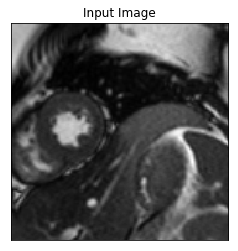

/opt/output/dsb/norm/1/3/train/205/sax_22_IM-9414-0007.dcm.npy


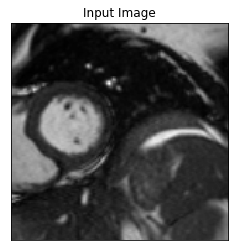

/opt/output/dsb/norm/1/3/train/205/sax_19_IM-9411-0008.dcm.npy


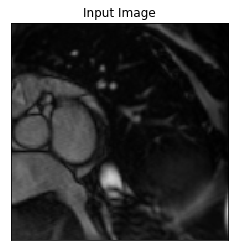

/opt/output/dsb/norm/1/3/train/205/sax_26_IM-9418-0013.dcm.npy


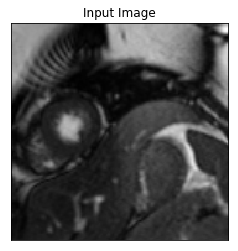

/opt/output/dsb/norm/1/3/train/205/sax_22_IM-9414-0014.dcm.npy


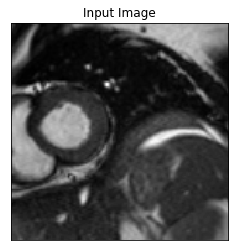

Final size of image set : 330 dropped images: 0
data path:  /opt/output/dsb/norm/1/3/train/205
Number of examples: 330
/opt/output/dsb/norm/1/3/train/205/sax_25_IM-9417-0013.dcm.npy /opt/output/dsb/norm/1/3/train/205/sax_22_IM-9414-0001.dcm.npy
Image 0 : 205 9417 13
Imae -1 : 205 9414 1
Processing 330 images and labels...
/opt/output/dsb/norm/1/3/train/205/sax_25_IM-9417-0013.dcm.npy


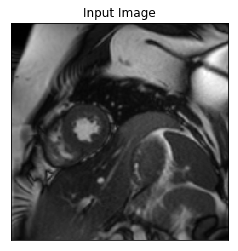

/opt/output/dsb/norm/1/3/train/205/sax_22_IM-9414-0007.dcm.npy


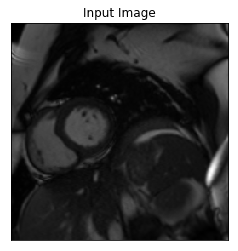

/opt/output/dsb/norm/1/3/train/205/sax_19_IM-9411-0008.dcm.npy


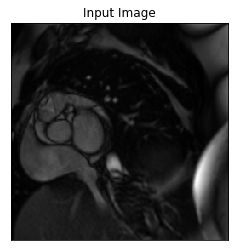

/opt/output/dsb/norm/1/3/train/205/sax_26_IM-9418-0013.dcm.npy


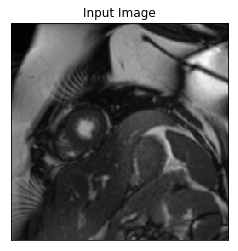

/opt/output/dsb/norm/1/3/train/205/sax_22_IM-9414-0014.dcm.npy


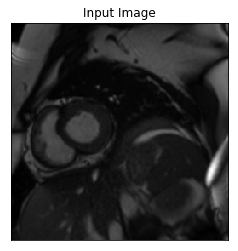

Final size of image set : 330 dropped images: 0
------------------------------
Converting data to np array, Input size :  330
------------------------------
Shape of image array :  (330, 176, 176, 1)
Max, min, mean values 718 10 108.5061485529364
Saved data as:  /masvol/heartsmart/unet_model/data/dsb205_176.npy
------------------------------
Converting data to np array, Input size :  330
------------------------------
Shape of image array :  (330, 256, 256, 1)
Max, min, mean values 1094 0 123.36957046046402
Saved data as:  /masvol/heartsmart/unet_model/data/dsb205_256.npy


In [50]:
# Read DSB3 data set one patient at at time and save them as 4d numpy array 
patient_record = "205"
data_path = DSB_TRAIN_IMG_DIR + patient_record
image_list, image_path_list, extracted_info = get_dsb_images(data_path, crop_size=176)
image_list2, image_path_list2, extracted_info2 = get_dsb_images(data_path, crop_size=256)

img_file = UNET_TRAIN_DIR + DSB_SOURCE + patient_record + "_176.npy"
convert_images_to_nparray_and_save (image_list, img_file, image_size = 176)

img_file2 = UNET_TRAIN_DIR + DSB_SOURCE + patient_record + "_256.npy"
convert_images_to_nparray_and_save (image_list2, img_file2, image_size = 256)

In [10]:
#########################################
#
# Loss functions
#
#########################################

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


def weighted_dice_coeff(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    return score


def weighted_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    if K.int_shape(y_pred)[1] == 128:
        kernel_size = 11
    elif K.int_shape(y_pred)[1] == 256:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 512:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 1024:
        kernel_size = 41
    else:
        raise ValueError('Unexpected image size')
    averaged_mask = K.pool2d(
        y_true, pool_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 1 - weighted_dice_coeff(y_true, y_pred, weight)
    return loss


def weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))

    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
                                          (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)



def my_bce_loss(y_true, y_pred):
#     y_true = K.cast(y_true, 'float32')
#     y_pred = K.cast(y_pred, 'float32')
 
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    #logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = (y_true * K.log(y_pred[i])) + ((1 - y_true) * K.log(1 - y_pred))
    return K.mean(loss, axis=-1)        
    #return K.sum(loss)
# def my_bce_loss(y_true, y_pred):
#     y_true_f = y_true.flatten()
#     y_pred_f = y_pred.flatten()
    
#     # avoiding overflow
#     epsilon = 1e-7
#     y_pred_f[y_pred_f<=0.] = epsilon
#     y_pred_f[y_pred_f>=1.] = 1. -epsilon
#     #y_pred = K.clip(y_pred_f, epsilon, 1. - epsilon)
#     #logit_y_pred = K.log(y_pred / (1. - y_pred))
#     result = []
#     result.append([y_true[i] * math.log(y_pred[i]) + (1 - y_true[i]) * math.log(1 - y_pred[i]) \
#                    for i in range(len(y_pred))])
#     return np.mean(result)



def penalized_bce_loss(weight):
    def weighted_bce_loss(y_true, y_pred):
        # avoiding overflow
        epsilon = 1e-7
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        logit_y_pred = K.log(y_pred / (1. - y_pred))

        # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
        loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
        return K.sum(loss) / K.sum(weight)
    return weighted_bce_loss

def penalized_bce_loss2(weight):
    def weighted_bce_loss(y_true, y_pred):
        # avoiding overflow
        epsilon = 1e-7
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        logit_y_pred = K.log(y_pred / (1. - y_pred))

        # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
        loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
                                              (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
        return K.sum(loss) / K.sum(weight)
    return weighted_bce_loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    if K.int_shape(y_pred)[1] == 128:
        kernel_size = 11
    elif K.int_shape(y_pred)[1] == 256:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 512:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 1024:
        kernel_size = 41
    else:
        raise ValueError('Unexpected image size')
    averaged_mask = K.pool2d(
        y_true, pool_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + (1 - weighted_dice_coeff(y_true, y_pred, weight))
    return loss

########################################
# 
# Method to evaluate the performance of u-net by computing, logloss, precision, reccall, f1score etc
#
#################################################

def evaluate_performance(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    y_pred_r = np.round(y_pred_f)

    # avoiding overflow
    epsilon = 1e-7
    y_pred_f[y_pred_f<=0.] = epsilon
    y_pred_f[y_pred_f>=1.] = 1. -epsilon
    #y_pred = K.clip(y_pred_f, epsilon, 1. - epsilon)
    #logit_y_pred = K.log(y_pred / (1. - y_pred))
    perf = {}
    result = []
    result2 = []
    
    true_p = 0.0
    true_n = 0.0
    false_p = 0.0
    false_n = 0.0
    for i in range (len(y_pred_f)):
        result.append (y_true_f[i] * np.log(y_pred_f[i]) + (1 - y_true_f[i]) * np.log(1 - y_pred_f[i]))
        result2.append (y_true_f[i] * np.log2(y_pred_f[i]) + (1 - y_true_f[i]) * np.log2(1 - y_pred_f[i]))

        if (y_pred_r[i] == 0 and y_true_f[i] == 0):
            true_n += 1.
        elif (y_pred_r[i] == 0 and y_true_f[i] == 1):
            false_n += 1.
        elif (y_pred_r[i] == 1 and y_true_f[i] == 1):
            true_p += 1.
        elif (y_pred_r[i] == 1 and y_true_f[i] == 0):
            false_p += 1.
            
    loss = np.mean(result)
    loss2 = np.mean(result2)
    accuracy = (true_p + true_n)/(true_p + true_n + false_p + false_n)
    precision = true_p/(true_p + false_p)
    recall    = true_p/(true_p + false_n)
    f1_score = (2 * precision * recall)/(precision+recall)
    
    print (len(result), sum(result))
    print ("true_pos : %d, false_pos : %d, true_neg  %d, false_neg : %d"%(true_p, false_p, true_n, false_n))
    print ("accuracy : %f, precision : %f, recall  %f, f1_score : %f"%(accuracy, precision, recall, f1_score))
    print ("logloss : %f, log2loss : %f "%(loss, loss2))
    perf["logloss"] = loss
    perf["log2loss"] = loss2
    perf["true_positive"] = true_p
    perf["false_positive"] = false_p
    perf["true_negative"] = true_n
    perf["false_negative"] = false_n
    perf["accuracy"] = accuracy
    perf["precision"] = precision
    perf["recall"] = recall
    perf["f1_score"] = f1_score
    
    return perf

In [50]:
###############################
#
# Unet models
#
################################

class myUnet(object):

    def __init__(self, image_size = 256, model_type = "small"):
        self.img_rows = image_size
        self.img_cols = image_size
        self.model_type = model_type
        if model_type == "small":
            self.build_unet_small()
        elif model_type == "large":
            self.build_unet()
        elif model_type == "large2":
            self.build_unet()
        else :
            print ("Specify valid model_type (small, large, large2)")
            return

    def load_data(self, train_data, test_data):
        print('-'*30)
        print("loading data")
        self.train_images, self.train_labels = load_images_and_labels(train_data)
        self.test_images, self.test_labels = load_images_and_labels(test_data)       
        print("loading data done")
        print('-'*30)

    def build_unet_small(self):
        
        '''
        Input shape
        4D tensor with shape: (samples, channels, rows, cols) if data_format='channels_first' 
        or 4D tensor with shape: (samples, rows, cols, channels) if data_format='channels_last' (default format).
        
        Output shape
        4D tensor with shape: (samples, filters, new_rows, new_cols) if data_format='channels_first' or 
        4D tensor with shape: (samples, new_rows, new_cols, filters) if data_format='channels_last'. 
        rows and cols values might have changed due to padding.
        
        He_normal initialization: It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) 
        where  fan_in is the number of input units in the weight tensor.
        '''

        print('-'*30)
        print ("Building smaller version of U-net model")
        print('-'*30)
        
        inputs = Input((self.img_rows, self.img_cols,1))

        conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        print ("conv1 shape:",conv1.shape)
        conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        print ("conv1 shape:",conv1.shape)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        print ("pool1 shape:",pool1.shape)

        conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        print ("conv2 shape:",conv2.shape)
        conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        print ("conv2 shape:",conv2.shape)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        print ("pool2 shape:",pool2.shape)

        conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        print ("conv3 shape:",conv3.shape)
        conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        print ("conv3 shape:",conv3.shape)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        print ("pool3 shape:",pool3.shape)

        conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.2)(conv4)
        
        up5 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
        merge5 = concatenate([conv3,up5], axis = 3)
        conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5)
        conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        
        up6 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
        merge6 = concatenate([conv2,up6], axis = 3)
        conv6 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

        up7 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv1,up7], axis = 3)
        conv7 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

        conv8 = Conv2D(1, 1, activation = 'sigmoid')(conv7)

        self.model = Model(input = inputs, output = conv8)

        self.model.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coeff])
        #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])


    def build_unet(self):
        
        '''
        Input shape
        4D tensor with shape: (samples, channels, rows, cols) if data_format='channels_first' 
        or 4D tensor with shape: (samples, rows, cols, channels) if data_format='channels_last' (default format).
        
        Output shape
        4D tensor with shape: (samples, filters, new_rows, new_cols) if data_format='channels_first' or 
        4D tensor with shape: (samples, new_rows, new_cols, filters) if data_format='channels_last'. 
        rows and cols values might have changed due to padding.
        '''
        print('-'*30)
        print ("Building U-net model")
        print('-'*30)
        
        inputs = Input((self.img_rows, self.img_cols,1))

        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        print ("conv1 shape:",conv1.shape)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        print ("conv1 shape:",conv1.shape)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        print ("pool1 shape:",pool1.shape)

        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        print ("conv2 shape:",conv2.shape)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        print ("conv2 shape:",conv2.shape)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        print ("pool2 shape:",pool2.shape)

        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        print ("conv3 shape:",conv3.shape)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        print ("conv3 shape:",conv3.shape)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        print ("pool3 shape:",pool3.shape)

        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        #drop4 = Dropout(0.5)(conv4)
        drop4 = conv4
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.2)(conv5)

        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = concatenate([drop4,up6], axis = 3)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv3,up7], axis = 3)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = concatenate([conv2,up8], axis = 3)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = concatenate([conv1,up9], axis = 3)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

        self.model = Model(input = inputs, output = conv10)

        #self.model.compile(optimizer=RMSprop(lr=0.0001), loss=penalized_bce_loss(weight=0.08), metrics=['binary_accuracy'])
        #self.model.compile(optimizer=RMSprop(lr=0.0001), loss=dice_loss, metrics=[dice_coeff])

        #metrics=['accuracy'] calculates accuracy automatically from cost function. So using binary_crossentropy shows binary 
        #accuracy, not categorical accuracy.Using categorical_crossentropy automatically switches to categorical accuracy
        #One can get both categorical and binary accuracy by using metrics=['binary_accuracy', 'categorical_accuracy']
        
        self.model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [dice_coeff])
        #self.model.compile(optimizer = Adam(lr = 1e-4), loss = my_bce_loss, metrics = ['binary_accuracy'])
    
    def load_pretrained_weights(self, model_file):
        self.model_file = model_file
        print('-'*30)
        print('Loading pre-trained weights...')
        self.model.load_weights(self.model_file)
        print('-'*30)   

    def predict(self, test_image_array, test_label_array ="none"):
        self.test_images = test_image_array
        self.test_labels = test_label_array
        print('-'*30)
        print('predict test data....')
        self.predictions = self.model.predict(self.test_images, batch_size=1, verbose=1)
        print('-'*30)
        print('-'*30)
        if self.test_labels != "none" :
            scores = self.model.evaluate (self.predictions, self.test_labels, batch_size=4)
            print ("Prediction Scores before rounding", scores)

            pred2 = np.round(self.predictions)
            scores = self.model.evaluate (pred2,  self.test_labels, batch_size=4)
            print ("Prediction Scores after rounding", scores)

    def train_and_predict(self, model_file, batch_size = 4, nb_epoch = 10): 
        self.model_file = model_file #path to save the weights with best model
        model_checkpoint = ModelCheckpoint(self.model_file, monitor='loss',verbose=1, save_best_only=True)
        print('-'*30)
        print('Fitting model...')
        print('-'*30)
        self.history = self.model.fit(self.train_images, self.train_labels, batch_size, nb_epoch, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

        print('-'*30)
        print('predict test data....')
        self.predictions = self.model.predict(self.test_images, batch_size=1, verbose=1)
        scores = self.model.evaluate (self.predictions, self.test_labels, batch_size=4)
        print ("Prediction Scores", scores)
        pred_file = "predictions_sk2.npy"
        pred_file = UNET_TRAIN_DIR + pred_file
        np.save(pred_file, self.predictions)
        print('-'*30)
        
    
    def train_with_augmentation(self, model_file, batch_size = 4, nb_epoch = 10 ):

        sample_size, x_val, y_val, ax = self.train_images.shape

        self.model_file = model_file #path to save the weights with best model
        model_checkpoint = ModelCheckpoint(self.model_file, monitor='loss',verbose=1, save_best_only=True)
        
        # we create two instances with the same arguments
        data_gen_args = dict(
                             rotation_range=90.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2)
        
        image_datagen = ImageDataGenerator(**data_gen_args)
        mask_datagen = ImageDataGenerator(**data_gen_args)

        # Provide the same seed and keyword arguments to the fit and flow methods
        seed = 1
        image_generator = image_datagen.flow(self.train_images, y=None, seed = seed, batch_size=sample_size)
        mask_generator = mask_datagen.flow(self.train_labels,  y=None, seed = seed, batch_size=sample_size)
        train_generator = zip(image_generator, mask_generator)
        
        print('-'*30)
        print('Fitting model...')
        
        self.history = self.model.fit(self.train_images, self.train_labels, batch_size, nb_epoch, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
        
        MAX_AUG=2
        augmentation_round = 0
        for img_tr, mask_tr in train_generator:
                print ("Augmentation round: ", augmentation_round+1, img_tr.shape)
                s, x1, y1, p = img_tr.shape
                self.history = self.model.fit(img_tr, mask_tr, batch_size, nb_epoch, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
                augmentation_round += 1
                if (augmentation_round == MAX_AUG):
                      break
            
        
        print('-'*30)
        print('Run Predictions on test data')
        self.predictions = self.model.predict(self.test_images, batch_size=1, verbose=1)
        scores = self.model.evaluate (self.predictions, self.test_labels, batch_size=4)
        print ("Prediction Scores", scores)
        pred_file = "predictions_aug_sk1.npy"
        pred_file = UNET_TRAIN_DIR + pred_file
        np.save(pred_file, self.predictions)
        print('-'*30)
        

    def train_with_augmentation2(self, model_file, batch_size = 4, nb_epoch = 10 ):

        sample_size, x_val, y_val, ax = self.train_images.shape

        model_file = UNET_MODEL_DIR+'unet_aug2.hdf5' #path to save the weights with best model
        model_checkpoint = ModelCheckpoint(model_file, monitor='loss',verbose=1, save_best_only=True)
        
        # we create two instances with the same arguments
        data_gen_args = dict(featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=90.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2)
        
        image_datagen = ImageDataGenerator(**data_gen_args)
        mask_datagen = ImageDataGenerator(**data_gen_args)

        # Provide the same seed and keyword arguments to the fit and flow methods
        seed = 1
        image_datagen.fit(self.train_images, augment=True, seed=seed)
        mask_datagen.fit(self.train_labels, augment=True, seed=seed)

        # Provide the same seed and keyword arguments to the fit and flow methods
        seed = 1
        image_generator = image_datagen.flow(self.train_images, y=None, seed = seed, batch_size=sample_size)
        mask_generator = mask_datagen.flow(self.train_labels,  y=None, seed = seed, batch_size=sample_size)
        train_generator = zip(image_generator, mask_generator)
        
        print('-'*30)
        print('Fitting model...')
        
        self.model.fit(self.train_images, self.train_labels, batch_size, nb_epoch, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
        
        MAX_AUG=2
        augmentation_round = 0
        for img_tr, mask_tr in train_generator:
                print ("Augmentation round: ", augmentation_round+1, img_tr.shape)
                s, x1, y1, p = img_tr.shape
                self.model.fit(img_tr, mask_tr, batch_size, nb_epoch, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
                augmentation_round += 1
                if (augmentation_round == MAX_AUG):
                      break
            
        
        print('-'*30)
        print('Run Predictions on test data')
        self.predictions = self.model.predict(self.test_images, batch_size=1, verbose=1)
        
        pred_file = "predictions_aug_sk1.npy"
        pred_file = UNET_TRAIN_DIR + pred_file
        np.save(pred_file, self.predictions)
        print('-'*30)
        
    def save_img(self):
        pred_file = "predictions.npy"
        pred_file = UNET_TRAIN_DIR + pred_file
        print("array to image")
        imgs = np.load(pred_file)
        for i in range(imgs.shape[0]):
            img = imgs[i]
            img = array_to_img(img)
            img.save("./%d.jpg"%(i))

    def display_ytrue_ypred (self, num_images = 4, random_images = False, evaluate= False):
        # if there are no test labels then just display the predictions
        if self.test_labels == "none":
            self.display_ypred (num_images = num_images, random_images = False)
            return
        
        ts , tl= self.test_images, self.test_labels
        pred = self.predictions
        samples, x, y, z = pred.shape
        print ("samples, max, min ", samples, pred.max(), pred.min())
        pred2 = np.round(pred)
        if (evaluate == True) :
            scores = self.model.evaluate (pred, tl, batch_size=1)
            print ("Prediction Scores", scores)

            scores = self.model.evaluate (pred2, tl, batch_size=1)
            print ("Prediction Scores after rounding", scores)
        ##Print few images wih actual labels and predictions
        display_list = []

        if random_images == True:
            display_list = random.sample(range(0, samples), num_images)
        else :
            display_list = [i for i in range (num_images)]
            
        

        for i in display_list:
            f, axs = plt.subplots(1,4,figsize=(15,15))
            plt.subplot(141),plt.imshow(ts[i].reshape(x, y))
            plt.title('test image '+str(i)), plt.xticks([]), plt.yticks([])
            plt.subplot(142),plt.imshow(tl[i].reshape(x, y))
            plt.title('test label'), plt.xticks([]), plt.yticks([])
            plt.subplot(143),plt.imshow(pred2[i].reshape(x, y))
            plt.title('pred label'), plt.xticks([]), plt.yticks([])
            plt.subplot(144),plt.imshow(tl[i].reshape(x, y)), plt.imshow(pred2[i].reshape(x, y), 'binary', interpolation='none', alpha=0.5)
            plt.title('overlay'), plt.xticks([]), plt.yticks([])
            plt.show()
            
#             f, axs = plt.subplots(1,3,figsize=(15,15))
#             plt.subplot(131),plt.imshow(ts[i].reshape(x, y))
#             plt.title('test Image'+ str(i)), plt.xticks([]), plt.yticks([])
#             plt.subplot(132),plt.imshow(tl[i].reshape(x, y))
#             plt.title('test label'), plt.xticks([]), plt.yticks([])
#             plt.subplot(133),plt.imshow(pred[i].reshape(x, y))
#             plt.title('Predicted mask'), plt.xticks([]), plt.yticks([])
#             plt.show()
    
    
    def display_ypred (self, num_images = 4, random_images = False):
        ts = self.test_images
        pred = self.predictions
        samples, x, y, z = pred.shape
        print ("samples, max, min ", samples, pred.max(), pred.min())
        pred2 = np.round(pred)

        display_list = []

        if random_images == True:
            display_list = random.sample(range(0, samples), num_images)
        else :
            display_list = [i for i in range (num_images)]

        for i in display_list:
            f, axs = plt.subplots(1,3,figsize=(15,15))
            plt.subplot(131),plt.imshow(ts[i].reshape(x, y))
            plt.title('test image '+str(i)), plt.xticks([]), plt.yticks([])
            plt.subplot(132),plt.imshow(pred2[i].reshape(x, y))
            plt.title('prediction'), plt.xticks([]), plt.yticks([])
            plt.subplot(133),plt.imshow(ts[i].reshape(x, y)), plt.imshow(pred2[i].reshape(x, y), 'binary', interpolation='none', alpha=0.5)
            plt.title('overlay'), plt.xticks([]), plt.yticks([])
            plt.show()
        
    def plot_accuracy_and_loss(self):
        # list all data in history
        print(self.history.history.keys())
        history = self.history
        # summarize history for accuracy
        if 'dice_coeff' in self.history.history.keys():
            plt.plot(history.history['dice_coeff'])
            plt.plot(history.history['val_dice_coeff'])
            plt.title('model accuracy(dice_coeff)')
        elif 'val_acc' in self.history.history.keys():
            plt.plot(history.history['acc'])
            plt.plot(history.history['val_acc'])
            plt.title('model accuracy')
        elif 'categorical_accuracy' in self.history.history.keys():
            plt.plot(history.history['categorical_accuracy'])
            plt.plot(history.history['val_categorical_accuracy'])
            plt.title('categorical_accuracy')
        elif 'binary_accuracy' in self.history.history.keys():
            plt.plot(history.history['binary_accuracy'])
            plt.plot(history.history['val_binary_accuracy'])
            plt.title('binary_accuracy')
        else : 
            print ("new loss function, not in the list")
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()



In [51]:
#################
# Method to create a U-net model and train it
# Create a U-Net model, train the model and run the predictions and save the trained weights and predictions
#
##########################
# /masvol/heartsmart/unet_model/data/sunnybrook_176_train_images.npy 
# /masvol/heartsmart/unet_model/data/sunnybrook_176_train_images.npy 
# /masvol/heartsmart/unet_model/data/sunnybrook_176_train_labels.npy

def train_unet_model (source_path, model_path, source, image_size, batch_size, epochs, augmentation = False, model_summary = False):
    source_list = ["sunnybrook", "acdc", "combined"]
    if source not in source_list:
        print ("source ", source, " is not in list ", source_list)
        return 
    size_str = str(image_size)
    
    train_data = {}
    test_data = {}

    train_data["images"] = source_path + source + "_" + size_str + "_train_images.npy"
    train_data["labels"] = source_path + source + "_" + size_str+ "_train_labels.npy"
    test_data["images"] = source_path + source + "_" + size_str + "_test_images.npy"
    test_data["labels"] = source_path + source + "_" + size_str + "_test_labels.npy"

    model_file = model_path + source + "_" + size_str + '.hdf5'
    
    if not os.path.exists(source_path):
        print ("source path does not exist ", source_path)
        return
    
    if not os.path.exists(model_path):
        print ("creating dir ", model_path)
        os.makedirs(model_path)
            
    # get the u-net model and load train and test data
    myunet = myUnet(image_size = image_size, model_type = "large")
    myunet.load_data (train_data, test_data)

    if (model_summary == True):
        myunet.model.summary()
    
    if (augmentation == True) :
        res = myunet.train_with_augmentation(model_file, batch_size = batch_size, nb_epoch = epochs)
    else :
        res = myunet.train_and_predict(model_file, batch_size = batch_size, nb_epoch = epochs)
        
    return myunet
        
    #sess.run(myunet.train_and_predict(model_file, batch_size = 4, nb_epoch = 5))
    #res = myunet.train_and_predict(model_file, batch_size = 4, nb_epoch = 20)
    #res = myunet.train_with_augmentation(model, batch_size = 4, nb_epoch = 10)
    
############
#Method to train all models 
########################
def train_all_models( batch_size = 4, epochs = 10, augmentation = False):
    source_list = ["sunnybrook", "acdc", "combined"]
    img_size_list = [176, 256]
    for mysource in source_list :
        for img_size in img_size_list :
            mymodel = train_unet_model (source_path = UNET_TRAIN_DIR, model_path = UNET_MODEL_DIR, source = mysource, \
                         image_size= img_size, batch_size= batch_size, epochs= epochs, augmentation= augmentation, model_summary= False)

            mymodel.plot_accuracy_and_loss()
            mymodel.display_ytrue_ypred(num_images = 4, random_images = True, evaluate = True)
            
############
#Method to train all models 
########################            
def train_one_model(source, image_size, batch_size = 4, epochs = 10, augmentation = False):
    source_list = ["sunnybrook", "acdc", "combined"]
    img_size_list = [176, 256]
    if source not in source_list:
        print ("source ", source, " is not in list ", source_list)
        return
    if image_size not in img_size_list:
        print ("image size %d is not supported"%image_size)
        return 

    mymodel = train_unet_model (source_path = UNET_TRAIN_DIR, model_path = UNET_MODEL_DIR, source = source, \
                 image_size= image_size, batch_size= batch_size, epochs= epochs, augmentation= augmentation, model_summary= False)

    mymodel.plot_accuracy_and_loss()
    mymodel.display_ytrue_ypred(num_images = 4, random_images = True, evaluate = True)
    return mymodel

####################
# Prediction using pre-trained weights
###################

def predict_with_pretrained_weights(model_file, image_size, test_image_file, test_label_file = "none"):
    img_size_list = [176, 256]
    if image_size not in img_size_list:
        print ("image size %d is not supported"%image_size)
        return 
    
    size_str = str(image_size)
    
    test_data = {}
    test_data["images"] = test_image_file
    test_data["labels"] = test_label_file

    model_file = model_file

    print('-'*30)
    print ("Get Test images and labels...")
    if test_label_file == "none": 
        ts = load_images(test_image_file)
        tl = "none"
    else :
        ts , tl= load_images_and_labels(test_data)

    print('-'*30)
    print ("Creating U-net model...")
    myunet = myUnet(image_size = image_size, model_type = "large")
    print('-'*30)
    print ("Loading the pre-trained weights...")
    myunet.load_pretrained_weights(model_file)
    print('-'*30)

    print('Run predictions...')
    myunet.predict(test_image_array = ts, test_label_array = tl)
    print('-'*30)

    myunet.display_ytrue_ypred(num_images = 4, random_images = False, evaluate = False)
    return myunet




In [39]:
# Train a model by specifying training source , image size , training parameters, 


#test_model = train_one_model(source = "sunnybrook", img_size = 176, batch_size = 4, epochs = 10, augmentation = False)

In [ ]:

mysource = "sunnybrook"
img_size = 256
mymodel = train_unet_model (source_path = UNET_TRAIN_DIR, model_path = UNET_MODEL_DIR, source = mysource, \
                         image_size= img_size, batch_size= 4, epochs= 2, augmentation= False, model_summary= False)

mymodel.plot_accuracy_and_loss()
mymodel.display_ytrue_ypred(num_images = 4, random_images = True, evaluate = True)
#mymodel.display_ytrue_ypred(num_images = 6, random_images = True, evaluate = False)

##  Predictions on Sunnybrook or ACDC test images using pre-trained weights

------------------------------
Get Test images and labels...
------------------------------
load np arrays of images and labels...
------------------------------
Loading files :  /masvol/heartsmart/unet_model/data/sunnybrook_256_test_images.npy /masvol/heartsmart/unet_model/data/sunnybrook_256_test_labels.npy
shape, max, min, mean of original image set: (80, 256, 256, 1) 3071.0 0.0 114.81773
shape, max, min, mean after normalization  : (80, 256, 256, 1) 1.0 0.0 0.12337347
shape, max, min, mean of labels : (80, 256, 256, 1) 1.0 0.0 0.030335044
------------------------------
Creating U-net model...
------------------------------
Building U-net model
------------------------------
conv1 shape: (?, 256, 256, 64)
conv1 shape: (?, 256, 256, 64)
pool1 shape: (?, 128, 128, 64)
conv2 shape: (?, 128, 128, 128)
conv2 shape: (?, 128, 128, 128)
pool2 shape: (?, 64, 64, 128)
conv3 shape: (?, 64, 64, 256)
conv3 shape: (?, 64, 64, 256)
pool3 shape: (?, 32, 32, 256)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:172: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


------------------------------
Loading the pre-trained weights...
------------------------------
Loading pre-trained weights...
------------------------------
------------------------------
Run predictions...
------------------------------
predict test data....
80/80 [==============================] - 2s 23ms/step
------------------------------
------------------------------


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:199: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


80/80 [==============================] - 1s 18ms/step
Prediction Scores before rounding [0.44269238859415055, 0.023945850658856217]
80/80 [==============================] - 1s 14ms/step
Prediction Scores after rounding [0.4870919890701771, 0.00014566748031938915]
------------------------------
samples, max, min  80 1.0 0.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:342: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


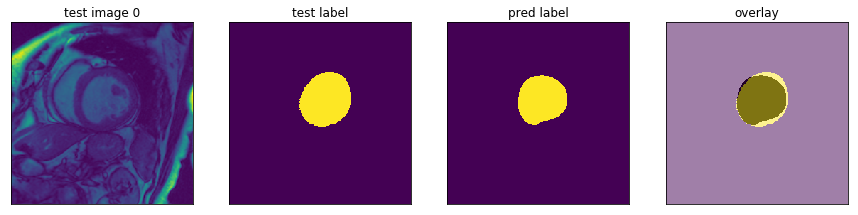

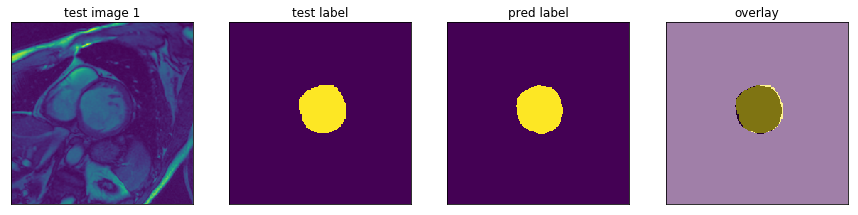

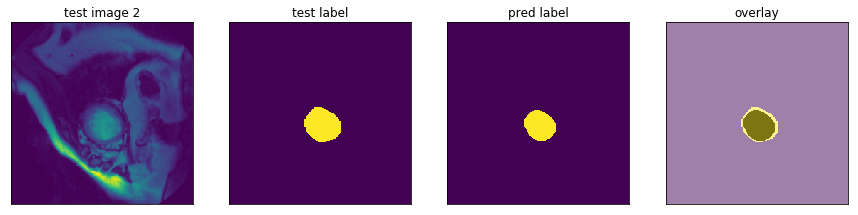

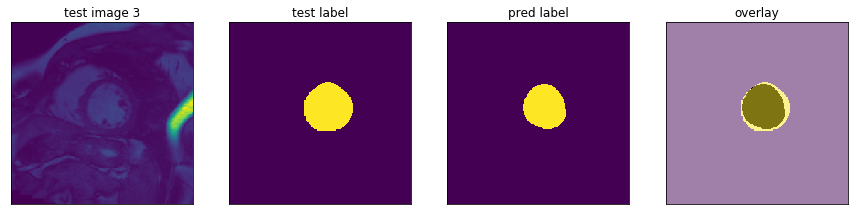

In [55]:
####################
# Prediction using pre-trained weights
###################

image_file = UNET_TRAIN_DIR + "sunnybrook_256_test_images.npy"
label_file = UNET_TRAIN_DIR + "sunnybrook_256_test_labels.npy" 


img_size = 256
model_file = "/masvol/heartsmart/unet_model/models/combined_256.hdf5"
mymodel = predict_with_pretrained_weights(model_file, image_size = img_size, \
                                test_image_file= image_file, test_label_file = label_file)

#save the predictions in the form of numpy array
# pred_file = "/masvol/heartsmart/unet_model/data/dsb200_256_predictions.npy"
# np.save(pred_file, mymodel.predictions)

In [56]:
# Get performance measures such as precision, recall, f1 score on the model
perf = evaluate_performance(mymodel.test_labels, mymodel.predictions)
print (perf)

5242880 -81235.9404990654
true_pos : 132134, false_pos : 6468, true_neg  5077369, false_neg : 26909
accuracy : 0.993634, precision : 0.953334, recall  0.830807, f1_score : 0.887863
logloss : -0.015495, log2loss : -0.022354 
{'recall': 0.8308067629509001, 'false_positive': 6468.0, 'log2loss': -0.02235387583200159, 'accuracy': 0.9936338424682617, 'false_negative': 26909.0, 'f1_score': 0.8878630583413126, 'precision': 0.9533340067242897, 'logloss': -0.015494526004483745, 'true_negative': 5077369.0, 'true_positive': 132134.0}


##  Predictions on DSB2 data using pre-trained weights

------------------------------
Get Test images and labels...
------------------------------
load np arrays of images ...
------------------------------
Loading files :  /masvol/heartsmart/unet_model/data/dsb200_256.npy
shape, max, min, mean of original image set: (270, 256, 256, 1) 536.0 0.0 49.6921
shape, max, min, mean after normalization  : (270, 256, 256, 1) 1.0 0.0 0.17271887
------------------------------
Creating U-net model...
------------------------------
Building U-net model
------------------------------
conv1 shape: (?, 256, 256, 64)
conv1 shape: (?, 256, 256, 64)
pool1 shape: (?, 128, 128, 64)
conv2 shape: (?, 128, 128, 128)
conv2 shape: (?, 128, 128, 128)
pool2 shape: (?, 64, 64, 128)
conv3 shape: (?, 64, 64, 256)
conv3 shape: (?, 64, 64, 256)
pool3 shape: (?, 32, 32, 256)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:172: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


------------------------------
Loading the pre-trained weights...
------------------------------
Loading pre-trained weights...
------------------------------
------------------------------
Run predictions...
------------------------------
predict test data....
270/270 [==============================] - 5s 19ms/step
------------------------------
------------------------------
------------------------------
samples, max, min  270 1.0 0.0


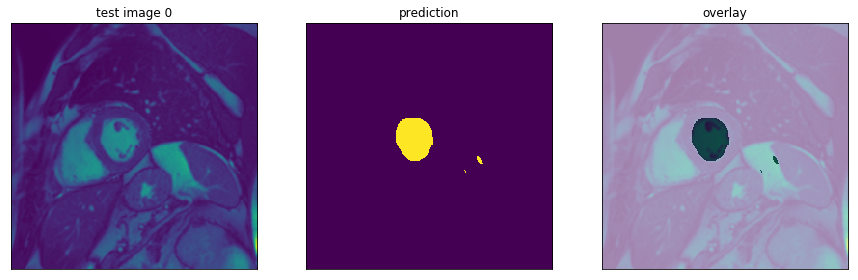

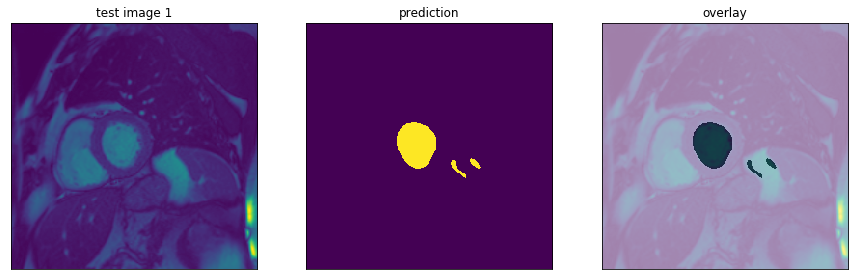

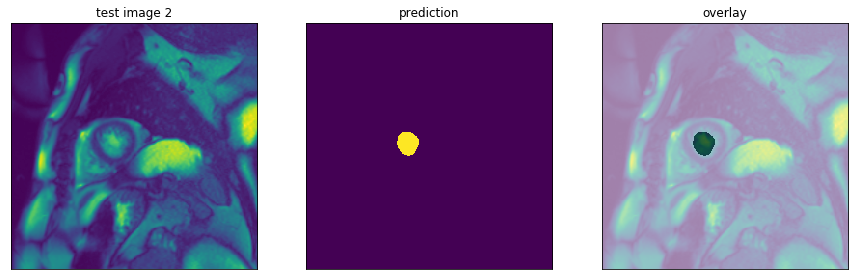

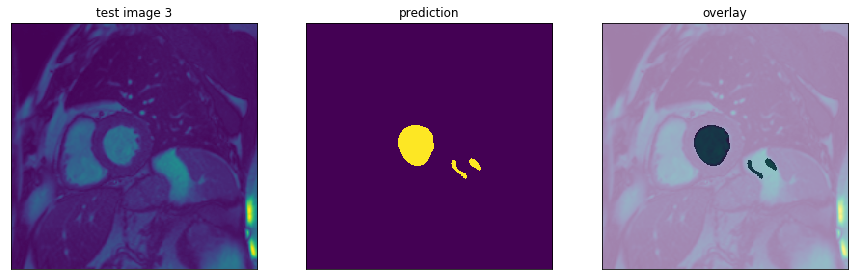

In [52]:
####################
# Prediction using pre-trained weights
###################

# image_file = UNET_TRAIN_DIR + "sunnybrook_256_test_images.npy"
# label_file = UNET_TRAIN_DIR + "sunnybrook_256_test_labels.npy" 

image_file = "/masvol/heartsmart/unet_model/data/dsb200_256.npy"
label_file = "none" 

img_size = 256
model_file = "/masvol/heartsmart/unet_model/models/combined_256.hdf5"
mymodel = predict_with_pretrained_weights(model_file, image_size = img_size, \
                                test_image_file= image_file, test_label_file = label_file)

#save the predictions in the form of numpy array
pred_file = "/masvol/heartsmart/unet_model/data/dsb200_256_predictions.npy"
np.save(pred_file, mymodel.predictions)

------------------------------
Get Test images and labels...
------------------------------
load np arrays of images ...
------------------------------
Loading files :  /masvol/heartsmart/unet_model/data/dsb200_176.npy
shape, max, min, mean of original image set: (270, 176, 176, 1) 395.0 1.0 57.302868
shape, max, min, mean after normalization  : (270, 176, 176, 1) 1.0 0.0 0.25621253
------------------------------
Creating U-net model...
------------------------------
Building U-net model
------------------------------
conv1 shape: (?, 176, 176, 64)
conv1 shape: (?, 176, 176, 64)
pool1 shape: (?, 88, 88, 64)
conv2 shape: (?, 88, 88, 128)
conv2 shape: (?, 88, 88, 128)
pool2 shape: (?, 44, 44, 128)
conv3 shape: (?, 44, 44, 256)
conv3 shape: (?, 44, 44, 256)
pool3 shape: (?, 22, 22, 256)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:172: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


------------------------------
Loading the pre-trained weights...
------------------------------
Loading pre-trained weights...
------------------------------
------------------------------
Run predictions...
------------------------------
predict test data....
270/270 [==============================] - 4s 14ms/step
------------------------------
------------------------------
------------------------------
samples, max, min  270 1.0 0.0


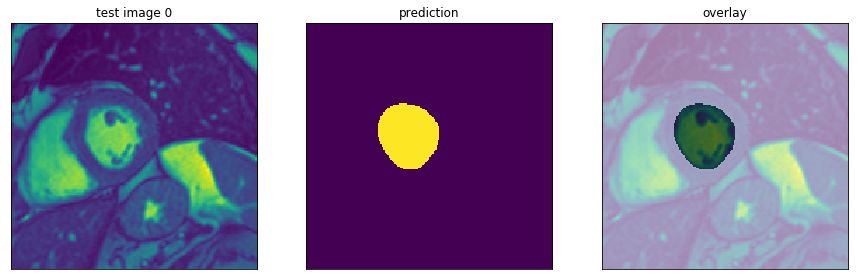

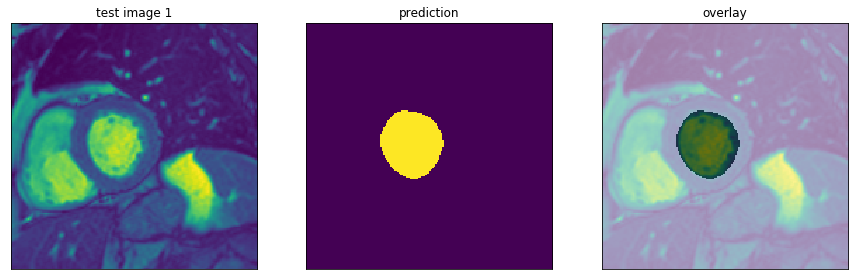

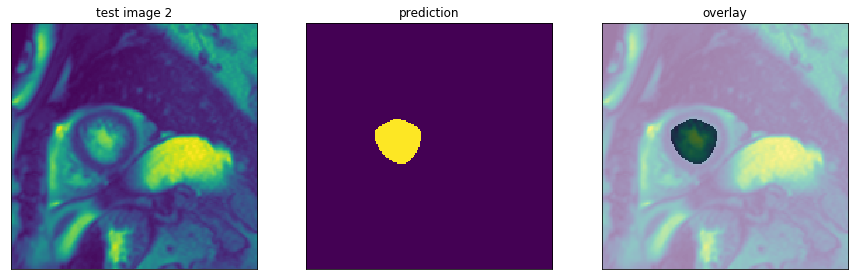

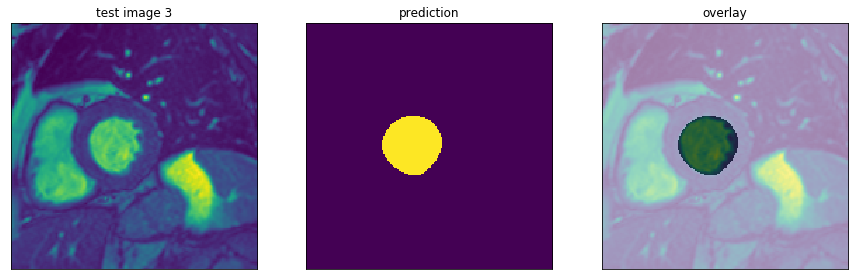

In [57]:
####################
# Prediction using pre-trained weights
###################

# image_file = UNET_TRAIN_DIR + "sunnybrook_256_test_images.npy"
# label_file = UNET_TRAIN_DIR + "sunnybrook_256_test_labels.npy" 

image_file = "/masvol/heartsmart/unet_model/data/dsb200_176.npy"
label_file = "none" 

img_size = 176
model_file = "/masvol/heartsmart/unet_model/models/combined_176.hdf5"
mymodel = predict_with_pretrained_weights(model_file, image_size = img_size, \
                                test_image_file= image_file, test_label_file = label_file)

#save the predictions in the form of numpy array
pred_file = "/masvol/heartsmart/unet_model/data/dsb200_176_predictions.npy"
np.save(pred_file, mymodel.predictions)

In [ ]:
#train_all_models( batch_size = 4, epochs = 2, augmentation = False)

In [31]:
#mymodel.display_ytrue_ypred(num_images = 6, random_images = True, evaluate = False)
